In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm
import scipy.signal
import IPython.display

from rlbase import misc
from rlbase.environment import MazeEnvironment,BlockingMazeEnvironment, ShortcutMazeEnvironment
from rlbase.policy import EpsGreedy
from rlbase.agent import QlearningAgent
from rlbase.experiment import TD_CtrlExperiment,DynaQExperiment, DynaQPlusExperiment
from rlbase.policy_functions import *

In [2]:
def maze_plot(i,episode):
    plt.clf()
    x = [a[0][0] for a in episode] + [env.terminal_states[0][0]]
    y = [a[0][1] for a in episode] + [env.terminal_states[0][1]]

    for idx, di in enumerate(["up","down","left","right"]):
        plt.subplot(6,2,idx+1)
        r = {s: agent.q[s][di] for s in env.states}
        plt.imshow(np.transpose(np.flip(env.reshape(r),axis=1)),origin="lower")
        plt.colorbar()
        plt.title(di)
    best_action = {k:misc.argmax_unique(v) for (k,v) in agent.q.items()}

    arrow_length = .3

    plt.subplot(6,2,(5,8))
    for j in range(env.sx+1):
      plt.plot([j-.5,j-.5],[-.5,env.sy-.5],'k-')
    for j in range(env.sy+1):
      plt.plot([-.5,env.sx-.5],[j-.5,j-.5],'k-')
    for (k,v) in best_action.items():
      dx, dy = (0,0)
      if "right" in v:
        dx += arrow_length
      if "up" in v:
        dy += arrow_length
      if "left" in v:
        dx -= arrow_length
      if "down" in v:
        dy -= arrow_length
      plt.arrow(k[0],k[1],dx,dy,color="r",head_width=0.1)
    plt.xlim(-.5,env.sx-.5)
    plt.ylim(-.5,env.sy-.5)
    plt.plot(env.start[0],env.start[1],"ob",markersize=12)
    for (x,y) in env.wall:
        plt.plot(x,y,"ok",markersize=12)
    plt.plot(env.terminal_states[0][0],env.terminal_states[0][1],"og",markersize=12)

    plt.subplot(6,2,(9,12))
    plt.plot(x,y,'-xk')
    for j in range(env.sx+1):
      plt.plot([j-.5,j-.5],[-.5,env.sy-.5],'k-')
    for j in range(env.sy+1):
      plt.plot([-.5,env.sx-.5],[j-.5,j-.5],'k-')
    for a in episode:
      dx, dy = (0,0)
      if "right" in a[1]:
        dx += arrow_length
      if "up" in a[1]:
        dy += arrow_length
      if "left" in a[1]:
        dx -= arrow_length
      if "down" in a[1]:
        dy -= arrow_length
      plt.arrow(a[0][0],a[0][1],dx,dy,color="r",head_width=0.1)
    plt.xlim(-.5,env.sx-.5)
    plt.ylim(-.5,env.sy-.5)
    plt.plot(env.start[0],env.start[1],"ob",markersize=12)
    for (x,y) in env.wall:
        plt.plot(x,y,"ok",markersize=12)
    plt.plot(episode[-1][0][0],episode[-1][0][1],"oy",markersize=12)
    plt.plot(env.terminal_states[0][0],env.terminal_states[0][1],"og",markersize=12)

    fig.canvas.draw()

In [3]:
%matplotlib notebook

fig, _ = plt.subplots(6,2,figsize=(5,7))
def plot(i,episode):
  if i%5==0:
    maze_plot(i,episode)

env = MazeEnvironment()
pi = EpsGreedy(env=env,eps=0.1)
agent = QlearningAgent(env=env,pi=pi,alpha=0.1)
exp = TD_CtrlExperiment(env=env,agent=agent,n_episodes=50,callback=plot,gamma=0.95,show_progress=False)
exp.train()

<IPython.core.display.Javascript object>

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

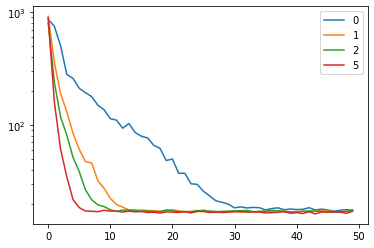

In [4]:
%matplotlib inline

n_episodes = 50
n_runs = 100
arr_n_plan = [0,1,2,5]

def data(i,episode):
  global tmp
  tmp[i] += len(episode)

env = MazeEnvironment()
lens = {}
for n_plan in arr_n_plan:
    tmp = [0]*n_episodes
    for i in tqdm(range(n_runs)):
        pi = EpsGreedy(env=env,eps=0.1)
        agent = QlearningAgent(env=env,pi=pi,alpha=0.1)
        exp = DynaQExperiment(env=env,agent=agent,n_episodes=n_episodes,callback=data,gamma=0.95,show_progress=False,n=n_plan)
        exp.train()
    lens[n_plan] = [i/n_runs for i in tmp]
    plt.semilogy(lens[n_plan])
plt.legend([str(i) for i in arr_n_plan])


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

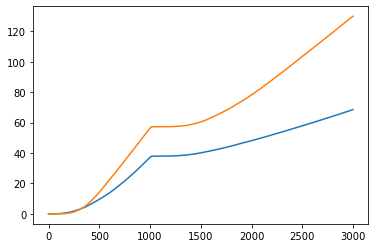

In [5]:
%matplotlib inline

n_runs = 100

t_change = 1000
t_max = 3000

def data(i,episode):
  global arr_r
  for (s,a,r) in episode:
    arr_r += [r]

models = ["DynaQ","DynaQ+"]
for model in models:
    v2 = np.zeros(t_max)
    for i in tqdm(range(n_runs)):
        env = BlockingMazeEnvironment()
        pi = EpsGreedy(env=env,eps=0.1)
        agent = QlearningAgent(env=env,pi=pi,alpha=1)
        arr_r = []
        opts = {"env":env,"agent":agent,"callback":data,"n_episodes":1,"gamma":0.95,\
               "show_progress":False,"n":10,"max_len":t_max,"weight":1e-4,"actions":env.actions}
        if model=="DynaQ":
          exp = DynaQExperiment(**opts)
        else:
          exp = DynaQPlusExperiment(**opts)
        while env.t < t_max:
            exp.train()
            if env.t > t_change:
              env.change()
        v = np.cumsum(arr_r) / n_runs
        v2 += v[0:t_max]
    plt.plot(v2)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

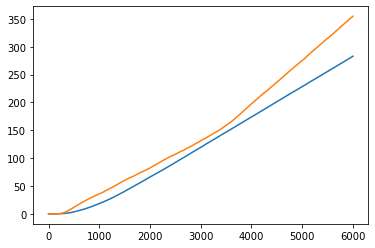

In [6]:
%matplotlib inline

n_runs = 20

t_change = 3000
t_max = 6000

def data(i,episode):
  global arr_r
  for (s,a,r) in episode:
    arr_r += [r]

models = ["DynaQ","DynaQ+"]
for model in models:
    v2 = np.zeros(t_max)
    for i in tqdm(range(n_runs)):
        env = ShortcutMazeEnvironment()
        pi = EpsGreedy(env=env,eps=0.1)
        agent = QlearningAgent(env=env,pi=pi,alpha=1)
        arr_r = []
        opts = {"env":env,"agent":agent,"callback":data,"n_episodes":1,"gamma":0.95,\
                "show_progress":False,"n":50,"max_len":t_max,"weight":1e-3,"actions":env.actions}
        if model=="DynaQ":
          exp = DynaQExperiment(**opts)
        else:
          exp = DynaQPlusExperiment(**opts)
        while env.t < t_max:
            exp.train()
            if env.t > t_change:
              env.change()
        v = np.cumsum(arr_r) / n_runs
        v2 += v[0:t_max]
    plt.plot(v2)